In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # 加入这行代码可以只使用cpu，对于自定义LSTM参数类训练，只使用cpu训练速度更快

In [1]:
import pandas as pd
import jieba
import re
import numpy as np

In [2]:
def word_cut(comments):
     words = jieba.cut(comments)
     return ','.join(words)# 以逗号连接分割后的词
#apply函数默认会按行应用word_cut函数

In [3]:
# 从txt文件中读取停止词
def Get_stopwords(path):
    stopwords=[]
    with open(path,encoding='utf-8') as words:
        stopwords.extend([i.strip() for i in words.readlines()])
    return stopwords
stopwords=Get_stopwords("./stopwords.txt")

In [4]:
def remove_stopwords(segmented_text):
     #字符串转为列表
     segmented_list = segmented_text.split(',')#根据逗号分隔符，将字符串转为列表
     #去停用词
     words_without_stopwords = []
     for w in segmented_list:
         if w not in stopwords:
             words_without_stopwords.append(w)
     return words_without_stopwords

In [5]:
# 从文件中读取comments和对应标签
def Get_comments_and_data(path):
    data=pd.read_csv(path,error_bad_lines=False)
    # 使用jieba库对comments进行语句切割
    data['Comment'] = data['Comment'].apply(word_cut)
    # 使用去停用词函数，去除comments中的停用词
    data['Comment'] = data['Comment'].apply(remove_stopwords)
    # 提取评论及评价
    comments=data['Comment'].values
    labels=data['label'].values
    # 转成列表
    comments=comments.tolist()
    labels=labels.tolist()
    return [comments,labels]
[comments,labels]=Get_comments_and_data("./new.csv")

C:\Users\CHEN\AppData\Local\Temp/ipykernel_58092/225220412.py:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data=pd.read_csv(path,error_bad_lines=False)
Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\CHEN\AppData\Local\Temp\jieba.cache
Loading model cost 2.525 seconds.
Prefix dict has been built successfully.


In [6]:
# 删除comments中的评论的''以及' '以及'\n'
def Remove_blanks(comments):
    for com in range(len(comments)):
        while ' ' in comments[com]:
            comments[com].remove(' ')
        while '' in comments[com]:
            comments[com].remove('')
        while '\n' in comments[com]:
            comments[com].remove('\n')
Remove_blanks(comments)

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [8]:
# 使用keras中自带的分词器统计前10000个出现的词，基于计数频率进行词嵌入，并转化为可以放入神经网络的sequence形式
maxlen=100 #  在100个词后截断评论
max_words=10000 # 考虑前10000个出现的词
def Trans_texts_to_seq(comments):
    global maxlen,max_words
    tokenizer=Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(comments)
    sequences=tokenizer.texts_to_sequences(comments)
    data=pad_sequences(sequences,maxlen=maxlen)
    return data

In [9]:
data=Trans_texts_to_seq(comments)

In [10]:
labels=np.asarray(labels)

In [11]:
def shuffle_data(data,labels):
    indices=np.arange(data.shape[0])
    np.random.shuffle(indices)
    data=data[indices]
    labels=labels[indices]

In [12]:
shuffle_data(data,labels)

In [ ]:
x_train=data[:200000]
y_train=labels[:200000]

In [16]:
from keras import layers
from keras import models
def Build_model():
    model=models.Sequential()
    model.add(layers.Embedding(max_words,maxlen,input_length=maxlen))
    model.add(layers.LSTM(128,return_sequences=True,dropout=0.2))
    model.add(layers.GlobalAveragePooling1D())
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dense(1,activation='sigmoid'))
    return model

In [17]:
def K_fold_validation(data,labels):
    k=5 # 5折交叉验证
    num_samples=len(data)//k
    shuffle_data(data,labels)
    validation_scores=[]
    num_epochs=10
    for fold in range(k):
        val_data=data[num_samples*fold:num_samples*(fold+1)]
        val_labels=labels[num_samples*fold:num_samples*(fold+1)]
        train_data=np.concatenate((data[:num_samples*fold],data[num_samples*(fold+1):]))
        train_labels=np.concatenate((labels[:num_samples*fold],labels[num_samples*(fold+1):]))
        model=Build_model()
        model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
        model.fit(train_data,train_labels,epochs=num_epochs,batch_size=128)
        loss,accuracy=model.evaluate(val_data,val_labels)
        validation_scores.append(accuracy)
        print("Next_fold")
    return sum(validation_scores)/k

In [15]:
scores=K_fold_validation(data,labels)
print(scores)

Epoch 1/10
1250/1250 [==============================] - 53s 43ms/step - loss: 0.6021 - acc: 0.6700
Epoch 2/10
1250/1250 [==============================] - 53s 42ms/step - loss: 0.5620 - acc: 0.7065
Epoch 3/10
1250/1250 [==============================] - 52s 42ms/step - loss: 0.5420 - acc: 0.7219
Epoch 4/10
1250/1250 [==============================] - 51s 41ms/step - loss: 0.5244 - acc: 0.7353
Epoch 5/10
1250/1250 [==============================] - 51s 41ms/step - loss: 0.5041 - acc: 0.7504
Epoch 6/10
1250/1250 [==============================] - 50s 40ms/step - loss: 0.4821 - acc: 0.7646
Epoch 7/10
1250/1250 [==============================] - 50s 40ms/step - loss: 0.4580 - acc: 0.7806
Epoch 8/10
1250/1250 [==============================] - 51s 41ms/step - loss: 0.4342 - acc: 0.7941
Epoch 9/10
1250/1250 [==============================] - 58s 46ms/step - loss: 0.4102 - acc: 0.8072
Epoch 10/10
1250/1250 [==============================] - 12s 9ms/step - loss: 0.7739 - acc: 0.6330
Epoch 1/10

In [27]:
model=Build_model()
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])

Epoch 1/10
1250/1250 [==============================] - 119s 95ms/step - loss: 0.7616 - acc: 0.6670 - val_loss: 0.5923 - val_acc: 0.6844
Epoch 2/10
1250/1250 [==============================] - 122s 97ms/step - loss: 12.0670 - acc: 0.7029 - val_loss: 0.5893 - val_acc: 0.6861
Epoch 3/10
1250/1250 [==============================] - 127s 101ms/step - loss: 24.7615 - acc: 0.7145 - val_loss: 0.6084 - val_acc: 0.6837
Epoch 4/10
1250/1250 [==============================] - 120s 96ms/step - loss: 9.5526 - acc: 0.7224 - val_loss: 842.7520 - val_acc: 0.6838
Epoch 5/10
1250/1250 [==============================] - 120s 96ms/step - loss: 399.0883 - acc: 0.7294 - val_loss: 0.6045 - val_acc: 0.6837
Epoch 6/10
1250/1250 [==============================] - 122s 98ms/step - loss: 391.4456 - acc: 0.7364 - val_loss: 0.5989 - val_acc: 0.6790
Epoch 7/10
1250/1250 [==============================] - 121s 97ms/step - loss: 216.8804 - acc: 0.7431 - val_loss: 13.6295 - val_acc: 0.6753
Epoch 8/10
1250/1250 [=======

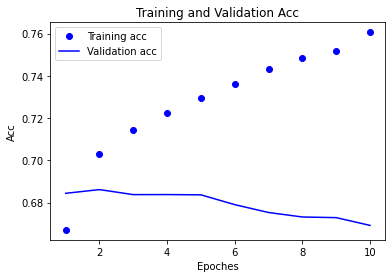

In [28]:
history=model.fit(x_train,y_train,
                 epochs=10,
                 batch_size=128,
                 validation_split=0.2)
import matplotlib.pyplot as plt

history_dict=history.history
loss_values=history_dict['acc']
val_loss_values=history_dict['val_acc']

epoches=range(1,len(loss_values)+1)

plt.plot(epoches,loss_values,'bo',label='Training acc')
plt.plot(epoches,val_loss_values,'b',label='Validation acc')
plt.title('Training and Validation Acc')
plt.xlabel('Epoches')
plt.ylabel('Acc')

plt.legend()
plt.show()